In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
class FoodStorage:

    def __init__(self, startingInsectFood, startingLegacyFood, percentInsect, legacyFillUpAmount,
                 legacyRefillFrequency):
        """
        Args:
        startingInsectFood (int): amount of insect food in kg.
        startingLegacyFood (int): amount of "legacy" food in kg.
        percentInsect (float)   : percentage of insectfood in animalfeed.
        legacyFillUpAmount (int): amount of legacyfood added to storage
        legacyRefillFrequency (int): days until next addition of legacy food to storage 
        
        """
        self.co2PerInsect = 1
        self.co2PerLegacy = 2
        self.legacyFillUpAmount = legacyFillUpAmount
        self.legacyRefillFrequency = datetime.timedelta(legacyRefillFrequency)
        self.legacyNextRefill = currentDate + self.legacyRefillFrequency
        self.insectFood = startingInsectFood
        self.legacyFood = startingLegacyFood
        self.percentInsect = percentInsect
        self.totalFood = self.insectFood + self.legacyFood
        self.minFood = (self.totalFood, currentDate)

    def eatFood(self, eaten):
        """
        Args:
        eaten (int/float): Amount eaten in kg .
        
        Returns: 
        co2 (float): CO2 emission from eaten amount.
        """
        co2 = 0
        if self.insectFood >= eaten*self.percentInsect:
            self.insectFood -= eaten*self.percentInsect
            self.legacyFood -= eaten*(1-self.percentInsect)
            co2 += eaten*self.percentInsect*self.co2PerInsect
            co2 += eaten*(1-self.percentInsect)*self.co2PerLegacy
        else:
            self.legacyFood -= eaten
            co2 = eaten*self.co2PerLegacy
        self.totalFood = self.insectFood + self.legacyFood
        if self.totalFood < self.minFood[0]:
            self.minFood = (self.totalFood, currentDate)
        return co2
        
    def addInsectFood(self, add):
        """
        Args:
        add (int): amount of insectfood added to storage.
        """
        self.insectFood += add
        
    def addLegacyFood(self, currentDate):
        """
        Args:
        add (int): amount of "legacy" food added to storage.
        """
        if currentDate == self.legacyNextRefill or currentDate > self.legacyNextRefill:
            self.legacyFood += self.legacyFillUpAmount
            self.legacyNextRefill = currentDate + self.legacyRefillFrequency

In [3]:
class InsectFarm:
    def __init__(self, sqrMeter, insectType, target):
        """
        Args:
        sqrMeter (int): Size of sqr. meters for insectfarm.
        insectType (string): Type of insect ("bi" or "larve").
        target (FoodStorage obj.): Where to put harvested insects.
        """
        insects = {'bi': (1, 14), 'larve': (5, 14)} #(food per sqmtr, time to harvest)
        self.nutrition = insects[insectType][0]*sqrMeter
        self.harvestFrequency = datetime.timedelta(days=insects[insectType][1])
        self.nextHarvest = currentDate + self.harvestFrequency
        self.target = target
        self.consumption = 1*sqrMeter
        
    def harvest(self,currentDate):
        """
        Return:
        self.nutrition (int/float): Amount harvested in kg.
        """
        if currentDate == self.nextHarvest or currentDate > self.nextHarvest:
            self.target.addInsectFood(self.nutrition)
            self.nextHarvest = currentDate + self.harvestFrequency
            return self.nutrition
        
        else:
            
            return 0

In [4]:
class Piggery:
    def __init__(self, startNoPiglets, startNoPigs, pigletNutritionNeeds, pigNutritionNeeds,
                 gestationTime, pigletTime, sellFrequency, litters, target, currentDate):
        """
        Args:
        startNoPiglets         (int): Amount of piglets in farm at day 0
        startNoPigs            (int): Amount of pigs in farm at day 0  
        pigletNutritionNeeds (float): Food per piglet per day (kg)
        pigNutritionNeeds    (float): Food per pig per day (kg)
        gestationTime          (int): Number of days in pigs gestation period
        pigletTime             (int): Number of days before a piglet becomes a pig
        sellFrequency          (int): Days before a pig is sold
        litters                (int): Number of piglet litters
        target    (FoodStorage obj.): Where to get food from
        currentDate      (time obj.): The current simulated date           
        # https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0141878.s001
        # Link with info regarding pig gestation
        """
        self.piglets = []
        self.pigs = []
        self.noPiglets = 0
        self.noPigs = 0
        self.startNoPiglets = startNoPiglets
        self.gestationFrequency = datetime.timedelta(int((gestationTime+pigletTime)/litters))
        self.pigletTime = datetime.timedelta(pigletTime)
        self.nextLitter = currentDate
        self.sellFrequency = datetime.timedelta(sellFrequency)
        self.pigletNutritionNeeds = pigletNutritionNeeds
        self.pigNutritionNeeds = pigNutritionNeeds
        self._addPiglets(startNoPiglets,currentDate)
        self._addPigs(startNoPigs,currentDate)
        self._updateNoPigs()
        self._updateNoPiglets()
        self.lastUpdateDate = currentDate
        self.target = target
        
    def _addPiglets(self, noPiglets,currentDate):
        """
        Args:
        noPiglets         (int): Number of piglets.
        currentDate (time obj.): The current simulated date.
        """
        if currentDate == self.nextLitter or currentDate > self.nextLitter:
            self.piglets.append((noPiglets,currentDate + self.pigletTime))
            self.nextLitter = currentDate+ self.gestationFrequency
    
    def _addPigs(self,noPigs,currentDate):
        """
        Args:
        noPigs            (int): Number of pigs.
        currentDate (time obj.): The current simulated date.
        """
        self.pigs.append((noPigs,currentDate + self.sellFrequency))
        
    def _movePiglets(self,currentDate):
        """
        Args:
        currentDate (time obj.): The current simulated date.
        """
        noPiglets = 0
        for i,litter in enumerate(self.piglets):
            if currentDate == litter[1] or currentDate > litter[1]:
                noPiglets += litter[0]
                self.piglets.pop(i)
                
        self._addPigs(noPiglets,currentDate)
        
    def _sellPigs(self, currentDate):
        """
        Args:
        currentDate (time obj.): The current simulated date.
        """
        for i,litter in enumerate(self.pigs):
            if currentDate == litter[1]:
                self.pigs.pop(i)

    def _eat(self,currentDate):
        """
        Args:
        currentDate (time obj.): The current simulated date.
        
        Returns:
        amountEaten (int): Amount of food eaten
        co2       (float): CO2 value of eaten food
        """
        days = (currentDate - self.lastUpdateDate).days +1
        pigletEat = self.noPiglets * self.pigletNutritionNeeds* days
        pigEat = self.noPigs * self.pigNutritionNeeds* days
        amountEaten = pigletEat+pigEat 
        co2 = self.target.eatFood(amountEaten)
        self.lastUpdateDate = currentDate
        
        return amountEaten, co2
                
    def _updateNoPigs(self):
        noPigs = 0
        for litter in self.pigs:
              noPigs +=litter[0]
                
        self.noPigs = noPigs
                
    def _updateNoPiglets(self):
        noPiglets = 0
        for litter in self.piglets:
              noPiglets +=litter[0]
        
        self.noPiglets = noPiglets
    
    def update(self,currentDate):
        """
        Args:
        currentDate (time obj.): The current simulated date.
        
        Returns:
        amountEaten (int): Amount of food eaten
        co2       (float): CO2 value of eaten food
        noPiglets   (int): Number of piglets in piggery
        noPigs   (int): Number of pigs in piggery
        """
        self._addPiglets(self.startNoPiglets,currentDate)
        self._movePiglets(currentDate)
        self._sellPigs(currentDate)
        self._updateNoPigs()
        self._updateNoPiglets()
        amountEaten,co2 = self._eat(currentDate)
        
        return amountEaten, co2, self.noPiglets, self.noPigs

# OPGAVER!
Piglets = sælges
årssøer = 360 (27 om året)


In [5]:
###############Settings####################
### Date settings ###
startdate = '01Jan2019'    # Start date as a string                 
stopdate = '01Jan2020'     # End date as a string
simulationInterval = 7     # Number of days per simulation point

### Food ###
startingInsectFood = 11    # Amount of insect food at day 0
startingLegacyFood = 40    # Amount of legacy food at day 0
percentInsect = 0.6        # Percent insects mixed in the food
legacyFillUpAmount = 30    # Amount of legacy food filled up at refill
legacyRefillFrequency = 7  # The frequency of legacy food refill in days

### Insect farm ###
sqrMeter=10                # Sqrmeters where insects are farmed
insectType='larve'         # Type of insect farmed

#### Piggery ###
startNoPiglets=10          # Number of piglets at day 0
startNoPigs=10             # Number of pigs at day 0
pigletNutritionNeeds=5     # Piglets nutrition needs
pigNutritionNeeds=4        # Pigs nutrition needs
gestationTime=115          # Frequency of gestation (115 days(gestation) + 4.5 weeks(baby))
pigletTime = 32            # Time piglets need to grow to become pigs
litters = 2                # Amount of pigs producing piglets (presumed to be out of sync litters)
sellFrequency=84           # Time pigs need to be fed before they are sold 
###########################################

In [6]:
# Prepare dates
currentDate = datetime.datetime.strptime(startdate, '%d%b%Y')
stopDate = datetime.datetime.strptime(stopdate, '%d%b%Y')

# Prepare objects
food = FoodStorage(startingInsectFood, startingLegacyFood, percentInsect,legacyFillUpAmount,legacyRefillFrequency)
farm = InsectFarm(sqrMeter, insectType, target=food)
piggery = Piggery(startNoPiglets, startNoPigs, pigletNutritionNeeds, pigNutritionNeeds, 
                  gestationTime,pigletTime, sellFrequency,litters, target=food,currentDate=currentDate)

# Prepare dataframe
df = pd.DataFrame(columns=['Month', 'Piglets', 'Pigs','Consumption','Harvested','CO2'])
df = df.set_index('Month')

# Loop over the selected dates
while currentDate != stopDate and currentDate < stopDate:
    
    eaten,co2,piglets,pigs = piggery.update(currentDate)
    
    # Add month/year(Sep19) row if not already present.
    if currentDate.strftime("%d%b%y") not in df.index.tolist():
        df.loc[currentDate.strftime("%d%b%y")] = [0,0,0,0,0]
        
    #Insect farm
    df.loc[currentDate.strftime("%d%b%y")].Harvested += farm.harvest(currentDate)
    
    # Foodstorage
    food.addLegacyFood(currentDate)  
    
    # Piggery
    df.loc[currentDate.strftime("%d%b%y")].Piglets += piglets
    df.loc[currentDate.strftime("%d%b%y")].Pigs += pigs
    df.loc[currentDate.strftime("%d%b%y")].Consumption += eaten
    df.loc[currentDate.strftime("%d%b%y")].CO2 += co2
    
    currentDate = currentDate+datetime.timedelta(days=7)

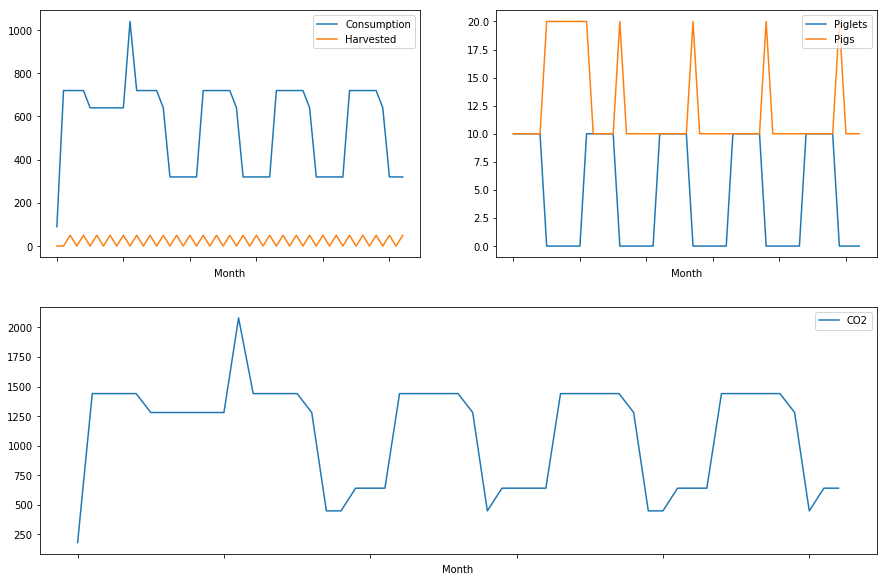

In [7]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(15,10));
#plt.figure()
ax = plt.subplot(gs[0, 0]) # row 0, col 0
df[['Consumption','Harvested']].plot(ax=ax);

ax = plt.subplot(gs[0, 1]) # row 0, col 1
df[['Piglets', 'Pigs']].plot(ax=ax);

ax = plt.subplot(gs[1, :]) # row 1, span all columns
df[['CO2']].plot(ax=ax);


In [8]:
df.describe(include='all')

,Piglets,Pigs,Consumption,Harvested,CO2
count,53,53,53,53,53.0
unique,2,2,5,2,6.0
top,0,10,720,0,1440.0
freq,28,42,23,27,23.0
